**Multivariate Multi-Step Time Series Forecasting Models for Air Pollution**

In [0]:
from google.colab import files
uploaded = files.upload()

Saving pollution.csv to pollution.csv
Saving raw.csv to raw.csv


In [0]:
import pandas as pd
import numpy as np
seed=123
np.random.seed(seed)
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


from sklearn import preprocessing
import time
from datetime import datetime
from math import sqrt
from pandas import read_csv, DataFrame, concat

In [0]:
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense,LSTM,GRU

In [32]:
from datetime import datetime
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

print ('import completed')


import completed


In [0]:
dataset = pd.read_csv('raw.csv', encoding="latin-1")

In [34]:
print('This dataset contains ',dataset.shape[0],'rows')
print('This dataset contains ',dataset.shape[1],'columns')

This dataset contains  43824 rows
This dataset contains  13 columns


In [62]:
dataset.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [64]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    43800 non-null float64
dew          43800 non-null int64
temp         43800 non-null float64
press        43800 non-null float64
wnd_dir      43800 non-null object
wnd_spd      43800 non-null float64
snow         43800 non-null int64
rain         43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [8]:
dataset.head(4)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0


**Combining the  Year Month Day Hour Columns**

In [0]:
from datetime import datetime
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset= pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [36]:
dataset.head(3)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0


In [0]:
dataset = dataset.drop("No",axis=1)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [38]:
dataset.head(3)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0


In [0]:
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]

In [0]:
dataset.to_csv("pollution.csv")

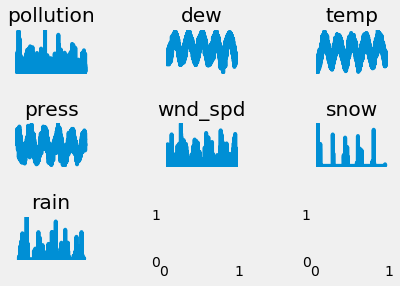

In [41]:
groups = [0, 1, 2, 3, 5, 6, 7]
values = dataset.values
fig,sub = plt.subplots(3,3)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(dataset.columns[i])

In [42]:
#preprocess the wind direction with label encoding
from sklearn.preprocessing import LabelEncoder
values = dataset.values
encoder = LabelEncoder()

values[:,4] = encoder.fit_transform(values[:,4])
values[:,4]

array([2, 2, 2, ..., 1, 1, 1], dtype=object)

In [43]:
#Scale the data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled[0]

array([0.12977867, 0.35294118, 0.24590164, 0.52727273, 0.66666667,
       0.00229001, 0.        , 0.        ])

In [0]:
#convert data to supervised form

def to_supervised(dataset,dropNa = True,lag = 1):
    df = pd.DataFrame(dataset)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = dataset.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [45]:
timeSteps = 2

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
2,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
3,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658
4,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0,0.105634


In [46]:
# spiltting the data
# training on only first year data
features = dataset.shape[1]
train_hours = 365*24
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(8760, 16) (35038, 16) (8760,) (35038,)


In [47]:
#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 1, features )

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print (x_train.shape,x_test.shape)

(8760, 2, 8) (35038, 2, 8)


In [48]:
print(x_train.shape)
print(x_test.shape)

(8760, 2, 8)
(35038, 2, 8)


In [0]:
# Defining the Model
import warnings
warnings.filterwarnings("ignore")

model = Sequential()
model.add( LSTM( 50, input_shape = ( timeSteps,x_train.shape[2]) ) )
model.add( Dense(1) )

model.compile( loss = "mae", optimizer = "adam")

history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 50 , batch_size = 72, verbose = 0, shuffle = False)

In [51]:
stop_noimprovement = EarlyStopping(patience=10)
history= model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,verbose=2,callbacks=[stop_noimprovement],shuffle=False)

Train on 8760 samples, validate on 35038 samples
Epoch 1/100
 - 2s - loss: 0.0148 - val_loss: 0.0162
Epoch 2/100
 - 2s - loss: 0.0153 - val_loss: 0.0158
Epoch 3/100
 - 2s - loss: 0.0144 - val_loss: 0.0158
Epoch 4/100
 - 2s - loss: 0.0149 - val_loss: 0.0168
Epoch 5/100
 - 2s - loss: 0.0145 - val_loss: 0.0145
Epoch 6/100
 - 2s - loss: 0.0147 - val_loss: 0.0145
Epoch 7/100
 - 2s - loss: 0.0144 - val_loss: 0.0153
Epoch 8/100
 - 2s - loss: 0.0143 - val_loss: 0.0154
Epoch 9/100
 - 2s - loss: 0.0146 - val_loss: 0.0154
Epoch 10/100
 - 2s - loss: 0.0147 - val_loss: 0.0152
Epoch 11/100
 - 2s - loss: 0.0145 - val_loss: 0.0145
Epoch 12/100
 - 2s - loss: 0.0145 - val_loss: 0.0143
Epoch 13/100
 - 2s - loss: 0.0143 - val_loss: 0.0144
Epoch 14/100
 - 2s - loss: 0.0145 - val_loss: 0.0144
Epoch 15/100
 - 2s - loss: 0.0146 - val_loss: 0.0143
Epoch 16/100
 - 2s - loss: 0.0144 - val_loss: 0.0145
Epoch 17/100
 - 2s - loss: 0.0144 - val_loss: 0.0144
Epoch 18/100
 - 2s - loss: 0.0144 - val_loss: 0.0150
Epoch 

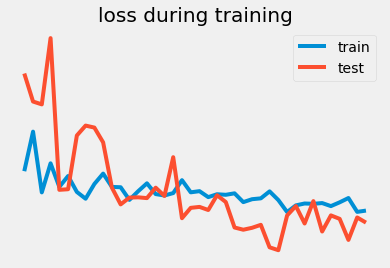

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

**The GRU Model**

In [89]:
# Trying out the GRU Model 
import warnings
warnings.filterwarnings("ignore")
from keras.layers.recurrent import LSTM, GRU

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('Model Compiled')

Model Compiled


In [0]:
#scale back the prediction to orginal scale
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred, x_test[:,-7:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-7:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

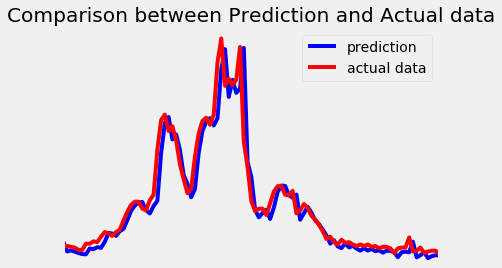

In [78]:
#plot the prediction with actual data

plt.plot(final_pred[:200], label = "prediction",c = "b")
plt.plot(actual_pred[:200],label = "actual data",c="r")
plt.xlim(0, 100)
plt.ylim(0, 300)
plt.yticks([])
plt.xticks([])
plt.title("Comparison between Prediction and Actual data")
plt.legend()

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print ("%f - mean absolute error")%(mean_absolute_error(final_pred,actual_pred))
print ("%f - mean squared error")%(mean_squared_error(final_pred,actual_pred))